In [183]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("/Users/isar/PycharmProjects/films-data-science/datasets/films-imdb/IMDb movies.csv", low_memory=False)
df = df[df['metascore'].notna()] # keep rows where metascore not NaN
df['isgood'] = np.where(df['metascore'] > 56, 1, 0)
df.head()
#df['isgood'].value_counts()
df.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
isgood                     int64
dtype: object

In [184]:
import re
from easymoney.money import EasyPeasy
ep = EasyPeasy()

occurences = {}

def find_occurence(x):
    if isinstance(x, str):
        occurences[re.sub('([\d.,\s])+','',x)] = None
    return None

df["budget"].apply(find_occurence)

print(occurences.keys(),c.currencies)

#df.iloc[0]["date_published"].year

dict_keys(['$', 'DEM', 'GBP', 'JPY', 'FRF', 'ITL', 'AUD', 'RUR', 'CAD', 'NZD', 'DKK', 'BEF', 'HKD', 'SEK', 'EUR', 'INR', 'ESP', 'ATS', 'NOK', 'THB', 'BRL', 'FIM', 'SGD', 'HUF', 'MXN', 'CNY', 'CZK', 'CHF', 'ZAR', 'KRW', 'ISK', 'PLN', 'CLP', 'NGN', 'ARS', 'ILS', 'DOP']) {'ISK', 'MYR', 'CNY', 'NOK', 'CAD', 'PHP', 'SIT', 'SKK', 'BRL', 'RUB', 'RON', 'MXN', 'SGD', 'MTL', 'TRL', 'JPY', 'EUR', 'THB', 'AUD', 'CYP', 'EEK', 'BGN', 'HUF', 'INR', 'HKD', 'PLN', 'USD', 'ROL', 'HRK', 'LTL', 'KRW', 'ZAR', 'ILS', 'NZD', 'SEK', 'DKK', 'CHF', 'GBP', 'TRY', 'LVL', 'CZK', 'IDR'}


In [185]:
# todo module currencyconverterinflation
from decimal import * # also pip install easymoney
from datetime import datetime

def clean_countries(x):
    result = None
    if isinstance(x, str):
        x = re.sub(',[^\n]*','',x)
        if x == "UK":
            result = "United Kingdom"
        elif x in ["Soviet Union", "Russia"]:
            result = "RU"
        elif x in ["South Korea"]:
            result = "KR"
        elif "Germany" in x:
            result = "Germany"
        else:
            result = x
        
    elif isinstance(x, list):
        result = x[0]
        
    return result

def clean_dates(x):
    if isinstance(x, str):
        x = re.sub('([A-z$.,\s])+','',x)
        if len(x) == 4:
            x+="-01-01"
        return datetime.strptime(x, '%Y-%m-%d')
    else:
        return x

def clean_currency(x):
    budget = x["budget"]
    
    if isinstance(budget, str):
        amt = re.sub('([A-z$.,\s])+','',budget)
        cur_type = re.sub('([\d.,\s])+','',budget)
        
        if cur_type in ['USD', '$']:
            reg = "US"
        else:
            reg = x["country"]
        
        try:
            return round(ep.normalize(amount=int(amt), 
                                      region=reg, 
                                      from_year=int(x["year"]), 
                                      base_currency="USD"), 2)
        except:
            #print("amount is "+amt, x["date_published"].year, x["country"])
            return None
    return(budget)
    
print(len(df.index)) # nb rows
df['country'] = df['country'].apply(clean_countries).astype('str')
df['date_published'] = df['date_published'].apply(clean_dates).astype('datetime64')
df = df[df['year'].notna()]
df = df[df['country'].notna()]
df = df[df['budget'].notna()]
df['budget'] = df.apply(clean_currency, axis=1).astype('float')
#df.dtypes
#df.loc[df['title'] == "Jeanne"]
#df.head()


13305


/Users/isar/.pyenv/versions/3.9.2/lib/python3.9/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1916 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/isar/.pyenv/versions/3.9.2/lib/python3.9/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1927 in 'Germany' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/isar/.pyenv/versions/3.9.2/lib/python3.9/site-packages/easymoney/money.py:213: UserWarning: 
Inflation (CPI) data for 1927 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 1960.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))
/Users/isar/.pyenv/versions/3.9

In [186]:
# %timeit -n10000 df.dtypes
#df["budget"].apply(type)
#df['budget_type'] = df['budget'].apply(lambda x: type(x).__name__)

In [187]:
tokeep =  ['genre', 'language', 'director', 'duration']

# on trie si il reste de NaN
for tk in tokeep:
    df = df[df[tk].notna()]
    
target = df["isgood"]
inputs = df.loc[:, tokeep]
inputs

,genre,language,director,duration
76,"Drama, History",English,D.W. Griffith,163
506,"Drama, Sci-Fi",German,Fritz Lang,153
566,"Drama, Music, Musical",English,Alan Crosland,88
628,"Comedy, Romance",English,Charles Chaplin,72
714,"Comedy, Musical",English,"Robert Florey, Joseph Santley",96
...,...,...,...,...
85460,"Animation, Drama, Family",Japanese,Makoto Shinkai,112
85503,Drama,"English, Italian, Russian",Abel Ferrara,115
85592,"Drama, History",English,Matthew E. Rosen,127
85618,Drama,English,Dan Sallitt,94


<IPython.core.display.Javascript object>


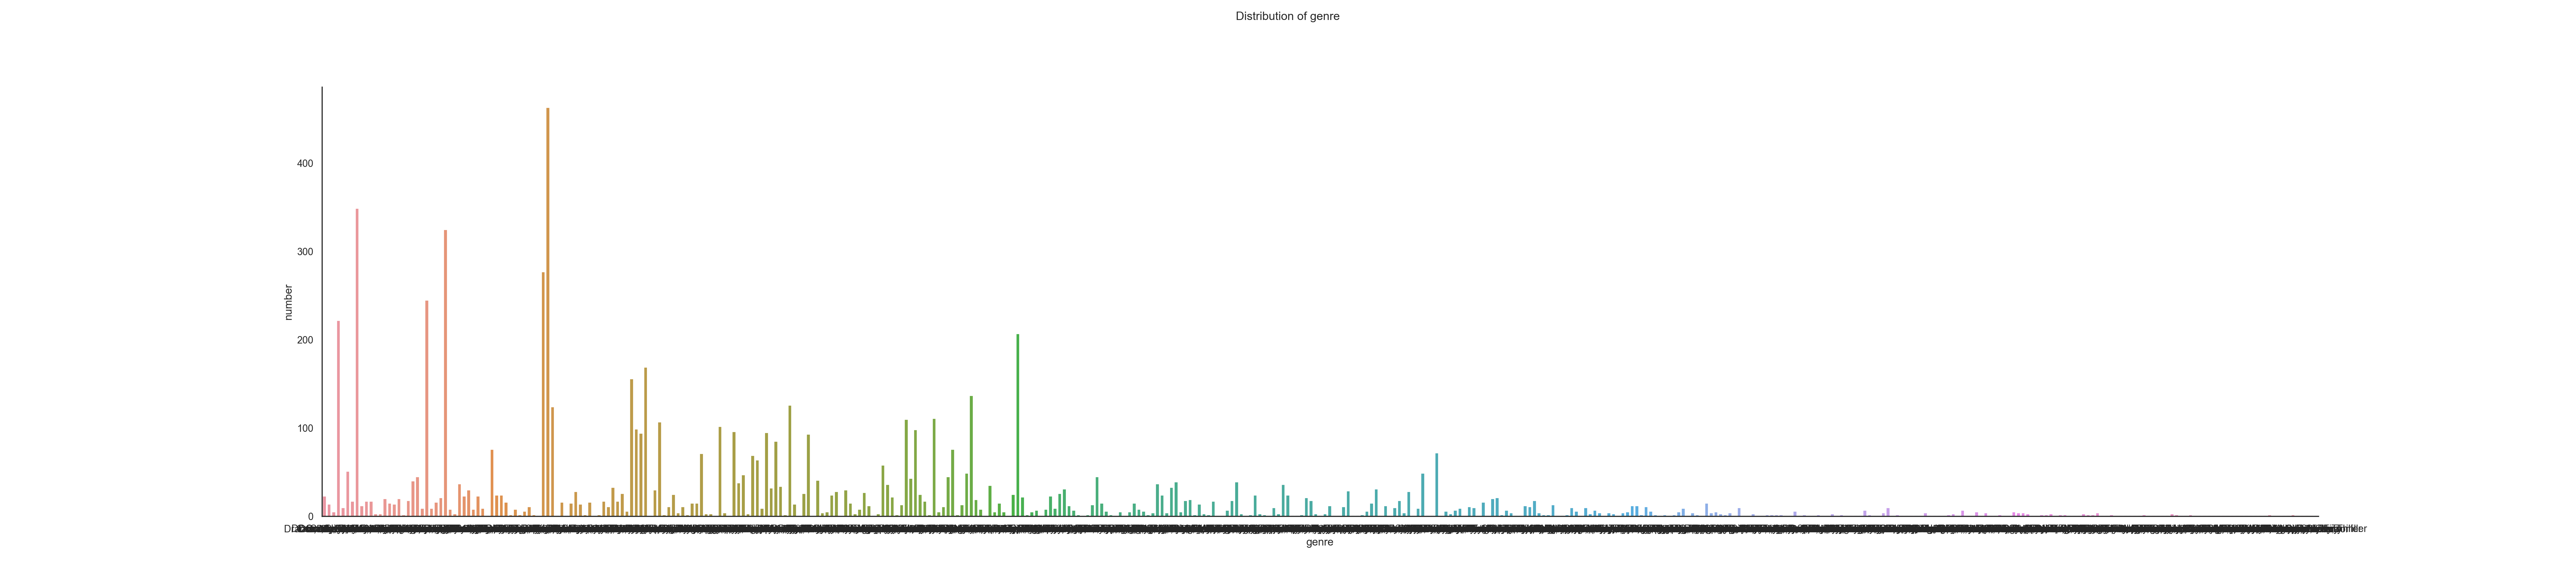

In [188]:
# for integrated graphs:
%matplotlib notebook

from modules import visumodule # pip install seaborn
import importlib
importlib.reload(visumodule)

vm = visumodule.Visualiser(df)

vm.distribution("genre")

In [189]:
from sklearn.preprocessing import LabelEncoder

In [190]:
inputs_dict = {}
for tk in tokeep:
    inputs_dict[tk] = LabelEncoder()

In [191]:
# transforme champ (str) en champ_n (int)
for tk in tokeep:
    inputs[tk+"_n"] = inputs_dict[tk].fit_transform(inputs[tk])
inputs.head()

,genre,language,director,duration,genre_n,language_n,director_n,duration_n
76,"Drama, History",English,D.W. Griffith,163,325,69,680,101
506,"Drama, Sci-Fi",German,Fritz Lang,153,362,880,1101,91
566,"Drama, Music, Musical",English,Alan Crosland,88,343,69,56,26
628,"Comedy, Romance",English,Charles Chaplin,72,257,69,510,10
714,"Comedy, Musical",English,"Robert Florey, Joseph Santley",96,251,69,2860,34


In [192]:
inputs_n = inputs.drop(tokeep,axis="columns")
inputs_n.head()

,genre_n,language_n,director_n,duration_n
76,325,69,680,101
506,362,880,1101,91
566,343,69,56,26
628,257,69,510,10
714,251,69,2860,34


In [193]:
from sklearn import tree # AVANT DE FAIRE UN ARBRE FAISONS DES CORRELATIONS VISUELLES

In [194]:
model = tree.DecisionTreeClassifier()

In [195]:
model.fit(inputs_n,target)

DecisionTreeClassifier()

In [196]:
#model.predict([[1462,125,294]])

In [197]:
nb_true = 0
nb_false = 0
for i in range(0, len(target)):
    inp = inputs_n.iloc[i]
    if target.iloc[i] == model.predict([inp]):
        nb_true+=1
    else:
        nb_false+=1
print(nb_true/(nb_true+nb_false))

# en fait on peut juste faire ça
model.score(inputs_n,target)

0.9992214869599065


0.9992214869599065

In [198]:
from sklearn.model_selection import train_test_split
input_train, input_test, target_train, target_test = train_test_split(inputs_n, target)

In [199]:
model_train = tree.DecisionTreeClassifier()
model_train.fit(input_train,target_train)


DecisionTreeClassifier()

In [200]:
model_train.score(input_train, target_train)

0.9993079584775086

In [201]:
model_train.score(input_test, target_test)

0.6004151530877011

In [202]:
# predict an actor's success?
# todo find most important features (ex: https://towardsdatascience.com/predicting-imdb-movie-ratings-using-supervised-machine-learning-f3b126ab2ddb)